# Construction of index from firm characteristics

This notebook builds a column index for each stock at a given date based on its firm's monthly characteristics. 
First we choose which way we want to merge the data, either by using the linking table to link gkey and PERMNO (A) or by using CUSIP (B).
Then, the approach uses partial least squares (PLS) trained on monthly cumulative returns to build the column index, capturing the most variation possible. 

In [45]:
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import rankdata
import gc
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import rankdata
import matplotlib.pyplot as plt
import seaborn as sns

## Step 1: From daily returns, compute cumulative returns over every month and stock 

## A: Linking table merging (don't run if using cusip data)

In [38]:
firms = pd.read_csv('Predictors/CompFirmCharac_sanitized.csv')
firms

,date,gvkey,cusip,acchgy,capxy,chechy,cogsy,cshfdy,cshpry,cstkey,...,oiadpy,opepsy,piy,revty,saley,spiy,txty,xidoy,xiy,xopry
0,2000-01-31,1013,000886309,0.0,46.785,21.138,291.300,182.525,174.925,0.0,...,67.400,0.31,68.400,593.900,593.900,0.000,15.300,0.000,0.0,496.900
1,2000-01-31,1082,81765M106,0.0,9.597,-2.956,117.073,2.936,2.936,0.0,...,5.287,0.31,1.503,131.177,131.177,0.000,0.590,-2.563,0.0,123.541
2,2000-01-31,1173,008015307,0.0,0.558,-0.754,14.390,3.937,3.937,0.0,...,0.894,0.07,0.482,23.271,23.271,0.000,0.222,0.000,0.0,21.847
3,2000-01-31,1183,45169P106,0.0,1.091,22.224,9.732,28.169,28.169,0.0,...,-3.652,-0.13,-17.342,7.476,7.476,-15.974,-3.286,0.741,0.0,9.732
4,2000-01-31,1189,008489502,0.0,17.181,-12.630,724.161,31.445,30.435,0.0,...,39.178,0.57,31.030,779.820,779.820,0.000,12.136,-0.007,0.0,724.161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873364,2025-03-31,34132,06652N107,0.0,4.197,53.154,9.600,9.552,9.422,0.0,...,16.473,1.10,13.713,9658.000,32.195,0.000,3.377,0.000,0.0,15.722
873365,2025-03-31,62243,913290102,0.0,0.693,-14.338,14.867,10.247,10.054,0.0,...,18.507,1.15,15.424,9658.000,42.902,0.000,3.826,0.000,0.0,24.395
873366,2025-03-31,124434,09290D101,0.0,255.000,4026.000,3443.000,156.600,155.000,0.0,...,1833.000,10.39,1763.000,5276.000,5276.000,-135.000,248.000,0.000,0.0,3443.000
873367,2025-03-31,185243,12618F105,0.0,2.395,-46.068,23.666,2.077,2.077,0.0,...,24.537,1.30,14.407,9658.000,75.407,0.000,2.823,0.000,0.0,50.870


In [39]:
daily = pd.read_csv('Targets/daily_crsp_sanitized.csv', usecols=['date', 'PERMCO', 'PERMNO', 'DlyRet'])

In [40]:
daily

,date,PERMCO,PERMNO,DlyRet
0,2000-01-03,5,15580,0.000000
1,2000-01-03,7,14593,0.088754
2,2000-01-03,25,62770,-0.061489
3,2000-01-03,29,59184,-0.012346
4,2000-01-03,33,59248,-0.034524
...,...,...,...,...
46468765,2024-12-31,60118,26023,-0.000393
46468766,2024-12-31,60120,26027,-0.194924
46468767,2024-12-31,60121,26034,0.108590
46468768,2024-12-31,60122,26035,-0.034979


In [6]:
linking = pd.read_csv('linking_table_sanitized.csv')
linking

,gvkey,LINKTYPE,PERMNO,PERMCO,LINKDT,LINKENDDT
0,1000,LU,25881,23369,1970-11-13,1978-06-30
1,1001,LU,10015,6398,1983-09-20,1986-07-31
2,1002,LC,10023,22159,1972-12-14,1973-06-05
3,1003,LU,10031,6672,1983-12-07,1989-08-16
4,1004,LU,54594,20000,1972-04-24,2099-12-31
...,...,...,...,...,...,...
33380,352262,LC,23773,59507,2023-03-17,2099-12-31
33381,353444,LC,23209,59330,2022-07-22,2099-12-31
33382,355398,LC,25134,59886,2024-05-17,2099-12-31
33383,356128,LC,24704,59765,2024-01-19,2099-12-31


In [7]:
# Ensure datetime 
daily['date'] = pd.to_datetime(daily['date'])

# Add a 'year_month' column
daily['year_month'] = daily['date'].dt.to_period('M')

# Group by PERMNO and year_month, then calculate cumulative return
monthly_cumret = (
    daily.groupby(['PERMNO', 'year_month'])['DlyRet']
    .apply(lambda x: (1 + x).prod() - 1)
    .reset_index()
)

# Convert year_month back to timestamp for sorting
monthly_cumret['date'] = monthly_cumret['year_month'].dt.to_timestamp()

# Sort by date and PERMNO
monthly_cumret = monthly_cumret.sort_values(['date', 'PERMNO'])

# Rename for clarity
monthly_cumret = monthly_cumret.rename(columns={'DlyRet': 'MonthlyRet'})
monthly_cumret

,PERMNO,year_month,MonthlyRet,date
0,10001,2000-01,-0.044118,2000-01-01
212,10002,2000-01,-0.025640,2000-01-01
370,10009,2000-01,-0.008475,2000-01-01
381,10012,2000-01,-0.097276,2000-01-01
449,10016,2000-01,-0.099339,2000-01-01
...,...,...,...,...
2229820,93426,2024-12,0.021768,2024-12-01
2229995,93427,2024-12,-0.062666,2024-12-01
2230263,93429,2024-12,-0.094742,2024-12-01
2230598,93434,2024-12,0.133332,2024-12-01


In [8]:
monthly_cumret = monthly_cumret.drop(columns=['year_month']) # No longer needed
monthly_cumret

,PERMNO,MonthlyRet,date
0,10001,-0.044118,2000-01-01
212,10002,-0.025640,2000-01-01
370,10009,-0.008475,2000-01-01
381,10012,-0.097276,2000-01-01
449,10016,-0.099339,2000-01-01
...,...,...,...
2229820,93426,0.021768,2024-12-01
2229995,93427,-0.062666,2024-12-01
2230263,93429,-0.094742,2024-12-01
2230598,93434,0.133332,2024-12-01


In [9]:
monthly_cumret.to_csv('Predictors/monthly_cum_ret.csv')

## B : Using the cusip data

In [54]:
firms_cusip = pd.read_csv('Predictors/CompFirmCharac_cusip_sanitized.csv')
firms_cusip

,date,gvkey,cusip,acchgy,capxy,chechy,cogsy,cshfdy,cshpry,cstkey,...,oiadpy,opepsy,piy,revty,saley,spiy,txty,xidoy,xiy,xopry
0,2000-01-31,1173,00801530,0.0,0.558,-0.754,14.390,3.937,3.937,0.0,...,0.894,0.07,0.482,23.271,23.271,0.000,0.222,0.000,0.000,21.847
1,2000-01-31,1240,01310410,0.0,1837.000,114.776,26252.071,423.245,422.320,0.0,...,1673.320,1.68,899.810,37478.079,37478.079,-432.881,472.421,-23.272,-23.272,34892.973
2,2000-01-31,1410,00095710,0.0,3.546,0.059,370.160,23.209,22.261,0.0,...,13.398,0.33,12.757,428.581,428.581,0.000,5.230,0.000,0.000,409.645
3,2000-01-31,1444,03037B10,0.0,0.057,-5.026,0.618,4.887,4.887,0.0,...,-1.762,-0.21,-1.496,0.000,0.000,0.000,-0.468,-0.590,0.000,1.747
4,2000-01-31,1562,02968310,0.0,1.462,-4.370,39.833,22.764,21.559,0.0,...,0.234,0.07,1.980,82.220,82.220,0.000,0.150,0.000,0.000,76.112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387540,2025-03-31,14225,31190010,0.0,55.700,-24.000,1030.800,574.800,573.500,0.0,...,393.900,0.52,393.100,1959.400,1959.400,0.000,94.400,0.000,0.000,1520.800
387541,2025-03-31,29466,31868710,0.0,0.642,-40.575,2.488,2.426,2.426,0.0,...,9.089,0.71,2.253,9658.000,25.595,0.000,0.561,0.000,0.000,11.256
387542,2025-03-31,34132,06652N10,0.0,4.197,53.154,9.600,9.552,9.422,0.0,...,16.473,1.10,13.713,9658.000,32.195,0.000,3.377,0.000,0.000,15.722
387543,2025-03-31,62243,91329010,0.0,0.693,-14.338,14.867,10.247,10.054,0.0,...,18.507,1.15,15.424,9658.000,42.902,0.000,3.826,0.000,0.000,24.395


In [55]:
daily_cusip = pd.read_csv('Targets/daily_crsp_cusip_sanitized.csv', usecols=['date', 'CUSIP', 'DlyRet'])
daily_cusip

,date,CUSIP,DlyRet
0,2000-01-03,04820910,0.000000
1,2000-01-03,03783310,0.088754
2,2000-01-03,03216510,-0.061489
3,2000-01-03,03522910,-0.012346
4,2000-01-03,03037B10,0.068182
...,...,...,...
20423729,2024-12-31,87165D20,0.055156
20423730,2024-12-31,74162310,0.006542
20423731,2024-12-31,09076J20,0.045685
20423732,2024-12-31,81764X10,-0.010104


In [56]:
# Ensure datetime 
daily_cusip['date'] = pd.to_datetime(daily_cusip['date'])

# Add a 'year_month' column
daily_cusip['year_month'] = daily_cusip['date'].dt.to_period('M')

# Group by PERMNO and year_month, then calculate cumulative return
monthly_cumret_cusip = (
    daily_cusip.groupby(['CUSIP', 'year_month'])['DlyRet']
    .apply(lambda x: (1 + x).prod() - 1)
    .reset_index()
)

# Convert year_month back to timestamp for sorting
monthly_cumret_cusip['date'] = monthly_cumret_cusip['year_month'].dt.to_timestamp()

# Sort by date and PERMNO
monthly_cumret_cusip = monthly_cumret_cusip.sort_values(['date', 'CUSIP'])

# Rename for clarity
monthly_cumret_cusip = monthly_cumret_cusip.rename(columns={'DlyRet': 'MonthlyRet'})
monthly_cumret_cusip

,CUSIP,year_month,MonthlyRet,date
61,00036020,2000-01,0.108694,2000-01-01
361,00036110,2000-01,-0.009483,2000-01-01
927,00075210,2000-01,0.196971,2000-01-01
949,00078810,2000-01,-0.046512,2000-01-01
1379,00086T10,2000-01,-0.118280,2000-01-01
...,...,...,...,...
979234,Y8166910,2024-12,0.041475,2024-12-01
979333,Y8172W10,2024-12,0.120692,2024-12-01
979746,Y8900D10,2024-12,0.128514,2024-12-01
979893,Y9390M10,2024-12,-0.028917,2024-12-01


In [57]:
monthly_cumret_cusip.to_csv('Predictors/monthly_cum_ret_cusip.csv')

## Step 2: Merge monthly returns with firm characteristics

## A: Using the linking table

In [14]:
monthly_cumret = pd.read_csv('Predictors/monthly_cum_ret.csv')
monthly_cumret = monthly_cumret.drop(columns=['Unnamed: 0']) 
monthly_cumret

,PERMNO,MonthlyRet,date
0,10001,-0.044118,2000-01-01
1,10002,-0.025640,2000-01-01
2,10009,-0.008475,2000-01-01
3,10012,-0.097276,2000-01-01
4,10016,-0.099339,2000-01-01
...,...,...,...
2230793,93426,0.021768,2024-12-01
2230794,93427,-0.062666,2024-12-01
2230795,93429,-0.094742,2024-12-01
2230796,93434,0.133332,2024-12-01


In [15]:
import pandas as pd
import numpy as np
from datetime import datetime
import gc

def memory_efficient_merge(linking_df_path, characteristics_df_path, returns_df_path, output_path=None):
    """
    Memory-efficient merging of firm characteristics with returns using linking table.
    
    Parameters:
    - linking_df_path: Path to linking table CSV
    - characteristics_df_path: Path to firm characteristics CSV
    - returns_df_path: Path to monthly returns CSV
    - output_path: Optional path to save merged output
    
    Returns:
    - Merged DataFrame (if output_path=None) or None (if output saved to file)
    """
    
    # 1. Process linking table first (smallest in memory)
    print("Loading linking table...")
    link_dtypes = {
        'gvkey': 'int32',
        'LINKTYPE': 'category',
        'PERMNO': 'int32',
        'PERMCO': 'int32',
        'LINKDT': 'str',
        'LINKENDDT': 'str'
    }
    linking_df = pd.read_csv(linking_df_path, dtype=link_dtypes)
    
    # Convert date columns to datetime
    linking_df['LINKDT'] = pd.to_datetime(linking_df['LINKDT'])
    linking_df['LINKENDDT'] = pd.to_datetime(linking_df['LINKENDDT'])
    
    # Create mapping dictionaries
    gvkey_to_permno = linking_df.set_index('gvkey')['PERMNO'].to_dict()
    permno_to_gvkey = linking_df.set_index('PERMNO')['gvkey'].to_dict()
    
    # 2. Process returns in chunks (largest dataset)
    print("Processing returns in chunks...")
    ret_dtypes = {
        'PERMNO': 'int32',
        'MonthlyRet': 'float32',
        'date': 'str'
    }
    
    # Initialize empty list to store merged chunks
    merged_chunks = []
    chunksize = 100000  # Adjust based on memory constraints
    
    # First pass: verify we can find matches
    test_ret_chunk = next(pd.read_csv(returns_df_path, dtype=ret_dtypes, chunksize=100))
    test_ret_chunk['date'] = pd.to_datetime(test_ret_chunk['date'])
    test_ret_chunk['gvkey'] = test_ret_chunk['PERMNO'].map(permno_to_gvkey)
    
    print(f"Sample returns with gvkey mapping:\n{test_ret_chunk.head()}")
    print(f"Number of returns with valid gvkey: {test_ret_chunk['gvkey'].notna().sum()}")
    
    # Second pass: process characteristics to verify format
    test_char_chunk = next(pd.read_csv(characteristics_df_path, chunksize=100))
    test_char_chunk['date'] = pd.to_datetime(test_char_chunk['date'])
    print(f"Characteristics date range: {test_char_chunk['date'].min()} to {test_char_chunk['date'].max()}")
    
    # Full processing if test passes
    for ret_chunk in pd.read_csv(returns_df_path, dtype=ret_dtypes, chunksize=chunksize):
        # Convert date column and ensure proper format
        ret_chunk['date'] = pd.to_datetime(ret_chunk['date'])
        ret_chunk['year_month'] = ret_chunk['date'].dt.to_period('M')
        
        # Map PERMNO to gvkey
        ret_chunk['gvkey'] = ret_chunk['PERMNO'].map(permno_to_gvkey)
        ret_chunk = ret_chunk[ret_chunk['gvkey'].notna()]
        
        if ret_chunk.empty:
            print("Warning: Empty returns chunk after gvkey mapping")
            continue
            
        ret_chunk['gvkey'] = ret_chunk['gvkey'].astype('int32')
        
        # Process characteristics in chunks
        for char_chunk in pd.read_csv(characteristics_df_path, chunksize=chunksize):
            char_chunk['date'] = pd.to_datetime(char_chunk['date'])
            char_chunk['year_month'] = char_chunk['date'].dt.to_period('M')
            
            # Merge on gvkey and year-month (more efficient than exact date)
            merged = pd.merge(
                ret_chunk,
                char_chunk,
                on=['gvkey', 'year_month'],
                how='inner'
            )
            
            if not merged.empty:
                merged_chunks.append(merged)
        
        # Clear memory
        gc.collect()
    
    if not merged_chunks:
        raise ValueError("No successful merges occurred. Check your data compatibility.")
    
    # Concatenate all merged chunks
    print("Concatenating merged chunks...")
    final_df = pd.concat(merged_chunks, ignore_index=True)
    
    # Drop temporary column and optimize memory
    final_df.drop(columns=['year_month'], inplace=True, errors='ignore')
    final_df = reduce_memory_usage(final_df)
    
    # Save or return result
    if output_path:
        print(f"Saving merged data to {output_path}...")
        final_df.to_csv(output_path, index=False)
        return None
    else:
        return final_df

def reduce_memory_usage(df):
    """Reduce memory usage of DataFrame by downcasting numeric columns"""
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
        elif col_type == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif col_type == 'object':
            if df[col].nunique() / len(df[col]) < 0.5:
                df[col] = df[col].astype('category')
    
    return df



In [16]:
# Run with garbage collection
gc.collect()
merged_data = memory_efficient_merge(
    linking_df_path='linking_table_sanitized.csv',
    characteristics_df_path='Predictors/CompFirmCharac_sanitized.csv',
    returns_df_path='Predictors/monthly_cum_ret.csv',
    output_path='Predictors/merged_data.csv'
)



Loading linking table...
Processing returns in chunks...
Sample returns with gvkey mapping:
   Unnamed: 0  PERMNO  MonthlyRet       date  gvkey
0           0   10001   -0.044118 2000-01-01  12994
1         212   10002   -0.025640 2000-01-01  19049
2         370   10009   -0.008475 2000-01-01  16739
3         381   10012   -0.097276 2000-01-01  11907
4         449   10016   -0.099339 2000-01-01   4641
Number of returns with valid gvkey: 100
Characteristics date range: 2000-01-31 00:00:00 to 2000-01-31 00:00:00
Concatenating merged chunks...
Saving merged data to Predictors/merged_data.csv...


## B : Using CUSIP

In [58]:
monthly_cumret_cusip = pd.read_csv('Predictors/monthly_cum_ret_cusip.csv')
monthly_cumret_cusip = monthly_cumret_cusip.drop(columns=['Unnamed: 0']) 
monthly_cumret_cusip



,CUSIP,year_month,MonthlyRet,date
0,00036020,2000-01,0.108694,2000-01-01
1,00036110,2000-01,-0.009483,2000-01-01
2,00075210,2000-01,0.196971,2000-01-01
3,00078810,2000-01,-0.046512,2000-01-01
4,00086T10,2000-01,-0.118280,2000-01-01
...,...,...,...,...
979999,Y8166910,2024-12,0.041475,2024-12-01
980000,Y8172W10,2024-12,0.120692,2024-12-01
980001,Y8900D10,2024-12,0.128514,2024-12-01
980002,Y9390M10,2024-12,-0.028917,2024-12-01


In [59]:
firms_cusip = pd.read_csv('Predictors/CompFirmCharac_cusip_sanitized.csv')

firms_cusip

,date,gvkey,cusip,acchgy,capxy,chechy,cogsy,cshfdy,cshpry,cstkey,...,oiadpy,opepsy,piy,revty,saley,spiy,txty,xidoy,xiy,xopry
0,2000-01-31,1173,00801530,0.0,0.558,-0.754,14.390,3.937,3.937,0.0,...,0.894,0.07,0.482,23.271,23.271,0.000,0.222,0.000,0.000,21.847
1,2000-01-31,1240,01310410,0.0,1837.000,114.776,26252.071,423.245,422.320,0.0,...,1673.320,1.68,899.810,37478.079,37478.079,-432.881,472.421,-23.272,-23.272,34892.973
2,2000-01-31,1410,00095710,0.0,3.546,0.059,370.160,23.209,22.261,0.0,...,13.398,0.33,12.757,428.581,428.581,0.000,5.230,0.000,0.000,409.645
3,2000-01-31,1444,03037B10,0.0,0.057,-5.026,0.618,4.887,4.887,0.0,...,-1.762,-0.21,-1.496,0.000,0.000,0.000,-0.468,-0.590,0.000,1.747
4,2000-01-31,1562,02968310,0.0,1.462,-4.370,39.833,22.764,21.559,0.0,...,0.234,0.07,1.980,82.220,82.220,0.000,0.150,0.000,0.000,76.112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387540,2025-03-31,14225,31190010,0.0,55.700,-24.000,1030.800,574.800,573.500,0.0,...,393.900,0.52,393.100,1959.400,1959.400,0.000,94.400,0.000,0.000,1520.800
387541,2025-03-31,29466,31868710,0.0,0.642,-40.575,2.488,2.426,2.426,0.0,...,9.089,0.71,2.253,9658.000,25.595,0.000,0.561,0.000,0.000,11.256
387542,2025-03-31,34132,06652N10,0.0,4.197,53.154,9.600,9.552,9.422,0.0,...,16.473,1.10,13.713,9658.000,32.195,0.000,3.377,0.000,0.000,15.722
387543,2025-03-31,62243,91329010,0.0,0.693,-14.338,14.867,10.247,10.054,0.0,...,18.507,1.15,15.424,9658.000,42.902,0.000,3.826,0.000,0.000,24.395


In [60]:
# Convert dates to datetime format for proper sorting
# Assuming monthly_cumret_cusip has dates in 'YYYY-MM-DD' format
monthly_cumret_cusip['date'] = pd.to_datetime(monthly_cumret_cusip['date'])

# Assuming firms_cusip has dates in 'YYYY-MM-DD' format  
firms_cusip['date'] = pd.to_datetime(firms_cusip['date'])

# Extract year-month for merging (since monthly returns are monthly data)
monthly_cumret_cusip['year_month'] = monthly_cumret_cusip['date'].dt.to_period('M')
firms_cusip['year_month'] = firms_cusip['date'].dt.to_period('M')

# Merge the datasets on CUSIP and year_month
# Using 'inner' join to keep only matching records
# monthly_cumret_cusip has 'CUSIP' (uppercase), firms_cusip has 'cusip' (lowercase)
merged_data = pd.merge(
    monthly_cumret_cusip, 
    firms_cusip, 
    left_on=['CUSIP', 'year_month'],
    right_on=['cusip', 'year_month'],
    how='inner',
    suffixes=('_returns', '_firms')
)

merged_data_sorted = merged_data.sort_values(['date_returns', 'CUSIP'], ascending=[True, True])

# Reset index after sorting
merged_data_cusip = merged_data_sorted.reset_index(drop=True)

merged_data_cusip.to_csv('merged_data_cusip.csv', index=False)

merged_data_cusip = merged_data_cusip.drop(columns=['year_month', 'cusip', 'date_returns', 'gvkey'])

merged_data_cusip



,CUSIP,MonthlyRet,date_firms,acchgy,capxy,chechy,cogsy,cshfdy,cshpry,cstkey,...,oiadpy,opepsy,piy,revty,saley,spiy,txty,xidoy,xiy,xopry
0,00089C10,0.181821,2000-01-31,0.0,4.862,-27.972,21.334,13.319,13.319,0.000,...,-16.974,-1.32,-17.571,42.563,42.563,0.000,0.000,0.0,0.0,55.492
1,00095710,0.013934,2000-01-31,0.0,3.546,0.059,370.160,23.209,22.261,0.000,...,13.398,0.33,12.757,428.581,428.581,0.000,5.230,0.0,0.0,409.645
2,00103110,0.237865,2000-01-31,0.0,3.932,0.439,127.540,7.567,7.443,0.000,...,3.729,-0.15,-1.954,163.846,163.846,0.000,-0.801,0.0,0.0,152.177
3,00289620,-0.199064,2000-01-31,0.0,83.824,-15.656,548.752,107.641,102.871,0.000,...,242.064,1.45,249.334,1042.056,1042.056,0.000,99.730,0.0,0.0,772.271
4,00371230,-0.414063,2000-01-31,0.0,2.065,-6.423,102.526,12.747,12.747,0.000,...,-10.386,-1.03,-9.110,106.915,106.915,3.710,0.296,0.0,0.0,114.493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316675,Y6213210,-0.019796,2024-12-31,0.0,41.402,-18.445,254.190,71.838,71.150,0.000,...,143.184,1.23,98.462,566.679,566.679,-2.285,4.365,0.0,0.0,290.770
316676,Y6417710,-0.041478,2024-12-31,0.0,11.189,-0.648,173.628,32.194,32.194,0.000,...,162.946,3.33,108.863,393.230,393.230,1.829,0.000,0.0,0.0,189.150
316677,Y7388L10,-0.065253,2024-12-31,0.0,144.775,32.497,123.637,107.576,107.576,0.000,...,111.872,0.83,97.376,320.679,320.679,0.000,0.000,0.0,0.0,150.672
316678,Y8166910,0.041475,2024-12-31,0.0,106.169,0.765,66.805,35.333,35.237,-2.559,...,59.812,1.91,69.862,167.262,167.262,0.000,0.000,0.0,0.0,81.373


## Step 3: Train PLS and extract index

## A

In [27]:
merged = pd.read_csv('Predictors/merged_data.csv')
merged

,Unnamed: 0,PERMNO,MonthlyRet,date_x,gvkey,date_y,cusip,acchgy,capxy,chechy,...,oiadpy,opepsy,piy,revty,saley,spiy,txty,xidoy,xiy,xopry
0,496,10025,2.378650e-01,2000-01-01,11903,2000-01-31,001031103,0.0,3.932,0.439,...,3.729,-0.15,-1.954,163.846,163.846,0.000,-0.801,0.000,0.0,152.177
1,3030,10089,-4.166620e-02,2000-01-01,12143,2000-01-31,020781100,0.0,0.314,-0.152,...,1.441,0.19,1.235,13.185,13.185,0.000,0.000,0.380,0.0,11.059
2,5640,10155,5.000001e-01,2000-01-01,12094,2000-01-31,284853306,0.0,0.085,0.125,...,-0.167,0.04,0.341,6.106,6.106,0.000,0.000,0.000,0.0,6.169
3,6353,10182,-1.785708e-01,2000-01-01,12171,2000-01-31,878237106,0.0,59.038,23.171,...,271.872,2.47,200.754,16991.750,16991.750,0.000,72.837,0.000,0.0,16662.036
4,9317,10256,-8.278109e-07,2000-01-01,12226,2000-01-31,59599U932,0.0,0.045,-1.493,...,0.027,0.01,0.017,4.167,4.167,0.000,-0.056,0.000,0.0,4.008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516861,2229820,93426,2.176763e-02,2024-12-01,185138,2024-12-31,92835K103,0.0,9.163,-4.693,...,18.106,0.82,17.564,306.522,306.522,-1.242,7.730,0.000,0.0,272.611
516862,2229995,93427,-6.266588e-02,2024-12-01,179583,2024-12-31,G3323L100,0.0,42.150,-6.402,...,156.638,4.54,175.648,1637.836,1637.836,-0.103,11.618,0.000,0.0,1455.402
516863,2230263,93429,-9.474157e-02,2024-12-01,184500,2024-12-31,12503M108,0.0,60.900,368.700,...,1183.900,8.08,1083.800,4093.500,4093.500,-111.400,318.900,0.000,0.0,2776.600
516864,2230598,93434,1.333318e-01,2024-12-01,184259,2024-12-31,785135302,0.0,0.195,1.107,...,-7.716,-5.21,-12.486,13.386,13.386,-0.840,0.003,-5.402,0.0,19.591


In [ ]:
def process_chunk(chunk):
    """
    Helper function to process a single chunk by rank-transforming each column.
    
    Parameters:
    -----------
    chunk : pd.DataFrame
        Input data chunk to process
        
    Returns:
    --------
    pd.DataFrame
        Processed chunk with rank-normalized values
    """
    chunk_processed = chunk.copy()
    for col in chunk.columns:
        x = chunk[col]
        non_missing = x.notna()
        x_non_missing = x[non_missing]
        
        if len(x_non_missing) > 0:
            ranks = rankdata(x_non_missing, method='average') - 1
            normalized = ranks / len(x_non_missing) - 0.5
            chunk_processed.loc[non_missing, col] = normalized
        
        chunk_processed.loc[~non_missing, col] = 0  # Impute missing with 0
    
    return chunk_processed

def preprocess_characteristics_with_pls(X_raw, y_raw, missing_threshold=0.3):
    """
    Preprocess firm characteristics and apply PLS for a single-value index.
    
    Parameters:
    -----------
    X_raw : pd.DataFrame
        Signal data with columns ['PERMNO', 'gvkey', 'date', ...features...]
    y_raw : pd.DataFrame  
        Target data with columns ['date', 'gvkey', 'MonthlyRet']
    missing_threshold : float, default=0.3
        Maximum fraction of missing values allowed per observation
        
    Returns:
    --------
    tuple
        (index_df, pls_model) where:
        - index_df: DataFrame with PLS index values
        - pls_model: Fitted PLSRegression model
    """
    dates = X_raw['date'].unique()
    results = []
    
    # First pass: collect and align data for PLS training
    all_chunks = []
    all_targets = []
    
    for date in dates:
        # Filter data for current date
        date_mask = X_raw['date'] == date
        date_chunk = X_raw[date_mask].copy()
        
        # Extract features (drop identifier columns)
        X_date = date_chunk.drop(columns=['PERMNO', 'date', 'gvkey'])
        
        # Filter out observations with too many missing values
        missing_frac = X_date.isna().mean(axis=1)
        eligible_mask = missing_frac <= missing_threshold
        
        if not eligible_mask.any():
            continue
        
        # Process eligible observations
        X_eligible = X_date[eligible_mask]
        gvkeys = date_chunk.loc[eligible_mask, 'gvkey'].values
        X_processed = process_chunk(X_eligible)
        
        # Match with target data - only keep firms that exist in both datasets
        y_date = y_raw[(y_raw['date'] == date) & (y_raw['gvkey'].isin(gvkeys))]
        
        if len(y_date) == 0:
            continue
            
        # Find intersection of gvkeys that exist in both datasets
        common_gvkeys = np.intersect1d(gvkeys, y_date['gvkey'].values)
        
        if len(common_gvkeys) == 0:
            continue
        
        # Filter features to only include firms with returns
        gvkey_mask = np.isin(gvkeys, common_gvkeys)
        X_processed_filtered = X_processed[gvkey_mask]
        
        # Get corresponding target values in same order
        y_date_indexed = y_date.set_index('gvkey')
        y_vals = y_date_indexed.loc[common_gvkeys]['MonthlyRet'].values
        
        all_chunks.append(X_processed_filtered)
        all_targets.append(y_vals)
    
    # Fit PLS model on all aligned data
    if len(all_chunks) == 0:
        raise ValueError("No matching data found between signals and returns datasets")
        
    X_all_df = pd.concat(all_chunks)
    X_all = X_all_df.values
    y_all = np.concatenate(all_targets)
    
    print(f"Training PLS with {len(X_all)} observations and {X_all.shape[1]} features")
    
    pls = PLSRegression(n_components=1)
    pls.fit(X_all_df, y_all)  # Use DataFrame to preserve feature names
    
    # Second pass: apply trained PLS model to generate index for each date
    for date in dates:
        # Filter data for current date
        date_mask = X_raw['date'] == date
        date_chunk = X_raw[date_mask].copy()
        
        # Extract features
        X_date = date_chunk.drop(columns=['PERMNO', 'date', 'gvkey'])
        
        # Filter out observations with too many missing values
        missing_frac = X_date.isna().mean(axis=1)
        eligible_mask = missing_frac <= missing_threshold
        
        if not eligible_mask.any():
            continue
        
        # Process eligible observations
        X_eligible = X_date[eligible_mask]
        gvkeys = date_chunk.loc[eligible_mask, 'gvkey'].values
        permnos = date_chunk.loc[eligible_mask, 'PERMNO'].values
        X_processed = process_chunk(X_eligible)
        
        # Match with target data
        y_date = y_raw[(y_raw['date'] == date) & (y_raw['gvkey'].isin(gvkeys))]
        
        if len(y_date) == 0:
            continue
            
        # Find intersection of gvkeys
        common_gvkeys = np.intersect1d(gvkeys, y_date['gvkey'].values)
        
        if len(common_gvkeys) == 0:
            continue
        
        # Filter to only include firms with returns
        gvkey_mask = np.isin(gvkeys, common_gvkeys)
        X_processed_filtered = X_processed[gvkey_mask]
        common_gvkeys_filtered = gvkeys[gvkey_mask]
        common_permnos_filtered = permnos[gvkey_mask]
        
        # Generate PLS index (first component score)
        index_values = pls.transform(X_processed_filtered)[:, 0]  # Use DataFrame to maintain consistency
        
        # Store results
        result_df = pd.DataFrame({
            'date': date,
            'PERMNO': common_permnos_filtered,
            'gvkey': common_gvkeys_filtered,
            'pls_index': index_values
        })
        results.append(result_df)
    
    # Combine all results
    index_df = pd.concat(results, ignore_index=True)
    
    print(f"Generated PLS index for {len(index_df)} firm-date observations")
    
    return index_df, pls



In [28]:
returns = merged[['date_y', 'gvkey', 'MonthlyRet']].copy()
returns = returns.rename(columns={'date_y': 'date'})
returns['date'] = pd.to_datetime(returns['date'])
returns

,date,gvkey,MonthlyRet
0,2000-01-31,11903,2.378650e-01
1,2000-01-31,12143,-4.166620e-02
2,2000-01-31,12094,5.000001e-01
3,2000-01-31,12171,-1.785708e-01
4,2000-01-31,12226,-8.278109e-07
...,...,...,...
516861,2024-12-31,185138,2.176763e-02
516862,2024-12-31,179583,-6.266588e-02
516863,2024-12-31,184500,-9.474157e-02
516864,2024-12-31,184259,1.333318e-01


In [ ]:
merged = merged.drop(['MonthlyRet', 'date_x', 'Unnamed: 0'], axis=1)
merged = merged.rename(columns={'date_y': 'date'})
merged['date'] = pd.to_datetime(merged['date'])
merged

,PERMNO,gvkey,date,acchgy,capxy,chechy,cogsy,cshfdy,cshpry,cstkey,...,oiadpy,opepsy,piy,revty,saley,spiy,txty,xidoy,xiy,xopry
0,10025,11903,2000-01-31,0.0,3.932,0.439,127.540,7.567,7.443,0.0,...,3.729,-0.15,-1.954,163.846,163.846,0.000,-0.801,0.000,0.0,152.177
1,10089,12143,2000-01-31,0.0,0.314,-0.152,8.855,7.091,6.578,0.0,...,1.441,0.19,1.235,13.185,13.185,0.000,0.000,0.380,0.0,11.059
2,10155,12094,2000-01-31,0.0,0.085,0.125,4.519,9.378,8.343,0.0,...,-0.167,0.04,0.341,6.106,6.106,0.000,0.000,0.000,0.0,6.169
3,10182,12171,2000-01-31,0.0,59.038,23.171,16000.244,58.508,51.693,0.0,...,271.872,2.47,200.754,16991.750,16991.750,0.000,72.837,0.000,0.0,16662.036
4,10256,12226,2000-01-31,0.0,0.045,-1.493,2.854,6.979,6.979,0.0,...,0.027,0.01,0.017,4.167,4.167,0.000,-0.056,0.000,0.0,4.008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516861,93426,185138,2024-12-31,0.0,9.163,-4.693,165.106,13.386,13.353,0.0,...,18.106,0.82,17.564,306.522,306.522,-1.242,7.730,0.000,0.0,272.611
516862,93427,179583,2024-12-31,0.0,42.150,-6.402,1412.165,36.405,36.183,0.0,...,156.638,4.54,175.648,1637.836,1637.836,-0.103,11.618,0.000,0.0,1455.402
516863,93429,184500,2024-12-31,0.0,60.900,368.700,2022.100,105.500,105.100,-3.9,...,1183.900,8.08,1083.800,4093.500,4093.500,-111.400,318.900,0.000,0.0,2776.600
516864,93434,184259,2024-12-31,0.0,0.195,1.107,10.167,2.287,2.287,0.0,...,-7.716,-5.21,-12.486,13.386,13.386,-0.840,0.003,-5.402,0.0,19.591


In [30]:
index_df, pls_model = preprocess_characteristics_with_pls(merged, returns)
index_df

Training PLS with 516866 observations and 39 features
Generated PLS index for 516866 firm-date observations


,date,PERMNO,gvkey,pls_index
0,2000-01-31,10025,11903,-3.353851
1,2000-01-31,10089,12143,-1.598444
2,2000-01-31,10155,12094,-2.988510
3,2000-01-31,10182,12171,6.884439
4,2000-01-31,10256,12226,-3.706980
...,...,...,...,...
516861,2024-12-31,93426,185138,-0.265275
516862,2024-12-31,93427,179583,3.481063
516863,2024-12-31,93429,184500,5.528594
516864,2024-12-31,93434,184259,-4.870555


## B

In [61]:
def process_chunk(chunk):
    """
    Helper function to process a single chunk by rank-transforming each column.
    
    Parameters:
    -----------
    chunk : pd.DataFrame
        Input data chunk to process
        
    Returns:
    --------
    pd.DataFrame
        Processed chunk with rank-normalized values
    """
    chunk_processed = chunk.copy()
    for col in chunk.columns:
        x = chunk[col]
        non_missing = x.notna()
        x_non_missing = x[non_missing]
        
        if len(x_non_missing) > 0:
            ranks = rankdata(x_non_missing, method='average') - 1
            normalized = ranks / len(x_non_missing) - 0.5
            chunk_processed.loc[non_missing, col] = normalized
        
        chunk_processed.loc[~non_missing, col] = 0  # Impute missing with 0
    
    return chunk_processed

def preprocess_characteristics_with_pls_cusip(X_raw, y_raw, missing_threshold=0.3):
    """
    Preprocess firm characteristics and apply PLS for a single-value index using CUSIP identifiers.
    
    Parameters:
    -----------
    X_raw : pd.DataFrame
        Signal data with columns ['CUSIP', 'date_firms', ...features...]
    y_raw : pd.DataFrame  
        Target data with columns ['CUSIP', 'MonthlyRet', 'date']
    missing_threshold : float, default=0.3
        Maximum fraction of missing values allowed per observation
        
    Returns:
    --------
    tuple
        (index_df, pls_model) where:
        - index_df: DataFrame with PLS index values
        - pls_model: Fitted PLSRegression model
    """
    # Detect date column names
    x_date_col = 'date_firms' if 'date_firms' in X_raw.columns else 'date'
    y_date_col = 'date' if 'date' in y_raw.columns else 'date_firms'
    
    # Use the date column from the dataset
    dates = X_raw[x_date_col].unique()
    results = []
    
    # First pass: collect and align data for PLS training
    all_chunks = []
    all_targets = []
    
    for date in dates:
        # Filter data for current date
        date_mask = X_raw[x_date_col] == date
        date_chunk = X_raw[date_mask].copy()
        
        # Extract features (drop identifier columns)
        # Identify columns to drop (CUSIP and date column)
        id_cols = ['CUSIP', x_date_col]
        # Also drop MonthlyRet if it exists in X_raw
        if 'MonthlyRet' in date_chunk.columns:
            id_cols.append('MonthlyRet')
        
        X_date = date_chunk.drop(columns=id_cols)
        
        # Filter out observations with too many missing values
        missing_frac = X_date.isna().mean(axis=1)
        eligible_mask = missing_frac <= missing_threshold
        
        if not eligible_mask.any():
            continue
        
        # Process eligible observations
        X_eligible = X_date[eligible_mask]
        cusips = date_chunk.loc[eligible_mask, 'CUSIP'].values
        X_processed = process_chunk(X_eligible)
        
        # Match with target data - only keep firms that exist in both datasets
        y_date = y_raw[(y_raw[y_date_col] == date) & (y_raw['CUSIP'].isin(cusips))]
        
        if len(y_date) == 0:
            continue
            
        # Find intersection of CUSIPs that exist in both datasets
        common_cusips = np.intersect1d(cusips, y_date['CUSIP'].values)
        
        if len(common_cusips) == 0:
            continue
        
        # Filter features to only include firms with returns
        cusip_mask = np.isin(cusips, common_cusips)
        X_processed_filtered = X_processed[cusip_mask]
        
        # Get corresponding target values in same order
        y_date_indexed = y_date.set_index('CUSIP')
        y_vals = y_date_indexed.loc[common_cusips]['MonthlyRet'].values
        
        all_chunks.append(X_processed_filtered)
        all_targets.append(y_vals)
    
    # Fit PLS model on all aligned data
    if len(all_chunks) == 0:
        raise ValueError("No matching data found between signals and returns datasets")
        
    X_all_df = pd.concat(all_chunks)
    X_all = X_all_df.values
    y_all = np.concatenate(all_targets)
    
    print(f"Training PLS with {len(X_all)} observations and {X_all.shape[1]} features")
    
    pls = PLSRegression(n_components=1)
    pls.fit(X_all_df, y_all)  # Use DataFrame to preserve feature names
    
    # Second pass: apply trained PLS model to generate index for each date
    for date in dates:
        # Filter data for current date
        date_mask = X_raw[x_date_col] == date
        date_chunk = X_raw[date_mask].copy()
        
        # Extract features
        id_cols = ['CUSIP', x_date_col]
        if 'MonthlyRet' in date_chunk.columns:
            id_cols.append('MonthlyRet')
        
        X_date = date_chunk.drop(columns=id_cols)
        
        # Filter out observations with too many missing values
        missing_frac = X_date.isna().mean(axis=1)
        eligible_mask = missing_frac <= missing_threshold
        
        if not eligible_mask.any():
            continue
        
        # Process eligible observations
        X_eligible = X_date[eligible_mask]
        cusips = date_chunk.loc[eligible_mask, 'CUSIP'].values
        X_processed = process_chunk(X_eligible)
        
        # Match with target data
        y_date = y_raw[(y_raw[y_date_col] == date) & (y_raw['CUSIP'].isin(cusips))]
        
        if len(y_date) == 0:
            continue
            
        # Find intersection of CUSIPs
        common_cusips = np.intersect1d(cusips, y_date['CUSIP'].values)
        
        if len(common_cusips) == 0:
            continue
        
        # Filter to only include firms with returns
        cusip_mask = np.isin(cusips, common_cusips)
        X_processed_filtered = X_processed[cusip_mask]
        common_cusips_filtered = cusips[cusip_mask]
        
        # Generate PLS index (first component score)
        index_values = pls.transform(X_processed_filtered)[:, 0]
        
        # Store results
        result_df = pd.DataFrame({
            'date': date,
            'CUSIP': common_cusips_filtered,
            'pls_index': index_values
        })
        results.append(result_df)
    
    # Combine all results
    index_df = pd.concat(results, ignore_index=True)
    
    print(f"Generated PLS index for {len(index_df)} firm-date observations")
    
    return index_df, pls

In [62]:
returns_cusip = merged_data_cusip[['date_firms', 'CUSIP', 'MonthlyRet']].copy()
returns_cusip = returns_cusip.rename(columns={'date_firms': 'date'})
returns_cusip['date'] = pd.to_datetime(returns_cusip['date'])
returns_cusip

,date,CUSIP,MonthlyRet
0,2000-01-31,00089C10,0.181821
1,2000-01-31,00095710,0.013934
2,2000-01-31,00103110,0.237865
3,2000-01-31,00289620,-0.199064
4,2000-01-31,00371230,-0.414063
...,...,...,...
316675,2024-12-31,Y6213210,-0.019796
316676,2024-12-31,Y6417710,-0.041478
316677,2024-12-31,Y7388L10,-0.065253
316678,2024-12-31,Y8166910,0.041475


In [63]:
index_df_cusip, pls_model_cusip = preprocess_characteristics_with_pls_cusip(merged_data_cusip, returns_cusip)
index_df_cusip

Training PLS with 316680 observations and 39 features
Generated PLS index for 316680 firm-date observations


,date,CUSIP,pls_index
0,2000-01-31,00089C10,-5.453753
1,2000-01-31,00095710,0.953656
2,2000-01-31,00103110,-3.549861
3,2000-01-31,00289620,4.326969
4,2000-01-31,00371230,-5.073071
...,...,...,...
316675,2024-12-31,Y6213210,1.149516
316676,2024-12-31,Y6417710,2.986176
316677,2024-12-31,Y7388L10,0.634677
316678,2024-12-31,Y8166910,1.475657


## Step 4: Inspect index to determine correlation with stock returns

## A

PLS MODEL INSPECTION
Number of components: 1
Number of features: 39
Feature names available: Yes (39 features)

FEATURE LOADINGS (X-weights):
----------------------------------------
Top 25 most important features:
feature   loading  abs_loading
 epsfiy  0.292308     0.292308
 epspiy  0.291666     0.291666
 epsfxy  0.290855     0.290855
 epspxy  0.290144     0.290144
 opepsy  0.263344     0.263344
 oepsxy  0.263248     0.263248
    niy  0.234614     0.234614
    piy  0.232567     0.232567
    iby  0.232269     0.232269
 dilavy  0.231660     0.231660
 ibcomy  0.230753     0.230753
 ibadjy  0.230043     0.230043
 oiadpy  0.186416     0.186416
   spiy  0.168118     0.168118
   txty  0.163210     0.163210
 oancfy  0.129482     0.129482
 cshpry -0.117583     0.117583
 cshfdy -0.112945     0.112945
 chechy  0.110382     0.110382
  capxy -0.108543     0.108543
 fincfy -0.096861     0.096861
 dilady  0.078315     0.078315
   miiy  0.069714     0.069714
  nopiy -0.069684     0.069684
  xidoy  0

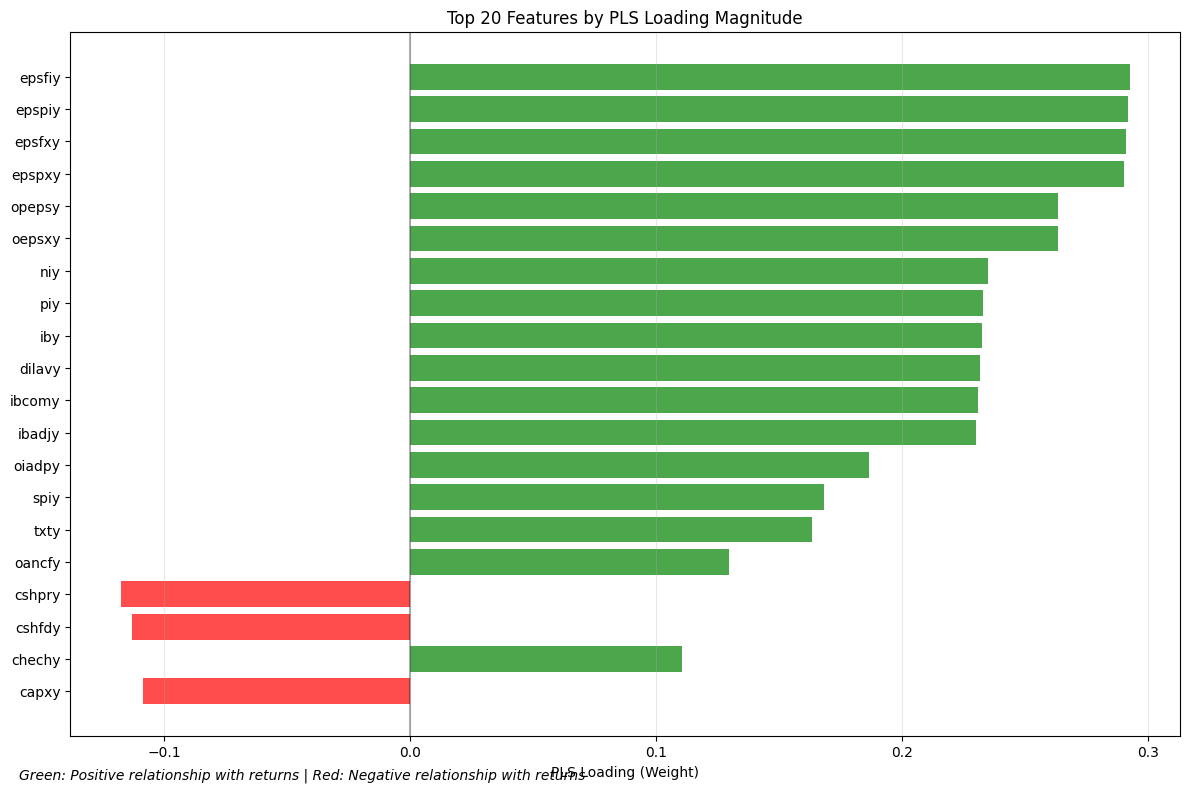

NameError: name 'merged' is not defined

In [ ]:
def inspect_pls_model(pls_model, feature_names=None, top_n=20):
    """
    Comprehensive inspection of a fitted PLS model.
    
    Parameters:
    -----------
    pls_model : PLSRegression
        Fitted PLS model
    feature_names : list, optional
        Names of features used in training
    top_n : int, default=20
        Number of top features to display
    """
    
    print("=" * 60)
    print("PLS MODEL INSPECTION")
    print("=" * 60)
    
    # 1. Basic model information
    print(f"Number of components: {pls_model.n_components}")
    print(f"Number of features: {pls_model.n_features_in_}")
    
    if hasattr(pls_model, 'feature_names_in_'):
        feature_names = pls_model.feature_names_in_
        print(f"Feature names available: Yes ({len(feature_names)} features)")
    else:
        print("Feature names available: No")
        if feature_names is None:
            feature_names = [f"Feature_{i}" for i in range(pls_model.n_features_in_)]
    
    print()
    
    # 2. Component loadings (weights) - these show how much each feature contributes
    print("FEATURE LOADINGS (X-weights):")
    print("-" * 40)

    # X loadings for first component
    x_loadings = pls_model.x_weights_[:, 0]  # First component
    
    # Create DataFrame for easier inspection
    loadings_df = pd.DataFrame({
        'feature': feature_names,
        'loading': x_loadings,
        'abs_loading': np.abs(x_loadings)
    }).sort_values('abs_loading', ascending=False)
    
    print(f"Top {top_n} most important features:")
    print(loadings_df.head(top_n).to_string(index=False))
    print()
    
    # 3. Explained variance
    if hasattr(pls_model, 'x_scores_') and hasattr(pls_model, 'y_scores_'):
        # Calculate explained variance for X
        x_var_explained = np.var(pls_model.x_scores_[:, 0]) / np.sum(np.var(pls_model.x_scores_, axis=0)) * 100
        print(f"Variance explained in X by first component: {x_var_explained:.2f}%")
        
        # Calculate explained variance for Y  
        y_var_explained = np.var(pls_model.y_scores_[:, 0]) / np.sum(np.var(pls_model.y_scores_, axis=0)) * 100
        print(f"Variance explained in Y by first component: {y_var_explained:.2f}%")
        print()
    
    # 4. Summary statistics of loadings
    print("LOADING STATISTICS:")
    print("-" * 20)
    print(f"Mean absolute loading: {np.mean(np.abs(x_loadings)):.4f}")
    print(f"Std of loadings: {np.std(x_loadings):.4f}")
    print(f"Max loading: {np.max(x_loadings):.4f}")
    print(f"Min loading: {np.min(x_loadings):.4f}")
    print()


    # 5. Features with highest positive and negative loadings
    print("DIRECTIONAL IMPORTANCE:")
    print("-" * 25)
    print(f"Top {min(10, top_n//2)} features with POSITIVE loadings (increase returns):")
    positive_features = loadings_df[loadings_df['loading'] > 0].head(min(10, top_n//2))
    for _, row in positive_features.iterrows():
        print(f"  {row['feature']}: {row['loading']:.4f}")
    
    print(f"\nTop {min(10, top_n//2)} features with NEGATIVE loadings (decrease returns):")
    negative_features = loadings_df[loadings_df['loading'] < 0].head(min(10, top_n//2))
    for _, row in negative_features.iterrows():
        print(f"  {row['feature']}: {row['loading']:.4f}")
    
    return loadings_df

def plot_pls_loadings(loadings_df, top_n=20, figsize=(12, 8)):
    """
    Plot the PLS loadings for visualization.
    
    Parameters:
    -----------
    loadings_df : pd.DataFrame
        DataFrame with feature loadings from inspect_pls_model
    top_n : int, default=20
        Number of top features to plot
    figsize : tuple, default=(12, 8)
        Figure size for the plot
    """
    
    # Plot top features by absolute loading
    plt.figure(figsize=figsize)
    
    # Get top features
    top_features = loadings_df.head(top_n).copy()

     # Create color map (positive = green, negative = red)
    colors = ['green' if x > 0 else 'red' for x in top_features['loading']]
    
    # Create horizontal bar plot
    plt.barh(range(len(top_features)), top_features['loading'], color=colors, alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('PLS Loading (Weight)')
    plt.title(f'Top {top_n} Features by PLS Loading Magnitude')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Add grid for easier reading
    plt.grid(axis='x', alpha=0.3)
    
    # Invert y-axis so highest absolute loading is at top
    plt.gca().invert_yaxis()
    
    # Add text explanation
    plt.figtext(0.02, 0.02, 'Green: Positive relationship with returns | Red: Negative relationship with returns', 
                fontsize=10, style='italic')
    
    plt.tight_layout()
    plt.show()

def analyze_pls_predictions(pls_model, X_test, y_test=None):
    """
    Analyze PLS model predictions and scores.
    
    Parameters:
    -----------
    pls_model : PLSRegression
        Fitted PLS model
    X_test : pd.DataFrame or np.array
        Test features
    y_test : array-like, optional
        Test targets for comparison
    """

    # Get PLS scores (the index values)
    pls_scores = pls_model.transform(X_test)[:, 0]
    
    print("PLS SCORES ANALYSIS:")
    print("-" * 25)
    print(f"Number of predictions: {len(pls_scores)}")
    print(f"Score statistics:")
    print(f"  Mean: {np.mean(pls_scores):.4f}")
    print(f"  Std: {np.std(pls_scores):.4f}")
    print(f"  Min: {np.min(pls_scores):.4f}")
    print(f"  Max: {np.max(pls_scores):.4f}")
    print(f"  25th percentile: {np.percentile(pls_scores, 25):.4f}")
    print(f"  75th percentile: {np.percentile(pls_scores, 75):.4f}")
    
    if y_test is not None:
        # Calculate correlation with actual returns
        correlation = np.corrcoef(pls_scores, y_test)[0, 1]
        print(f"\nCorrelation with actual returns: {correlation:.4f}")
    
    return pls_scores

PLS MODEL INSPECTION
Number of components: 1
Number of features: 39
Feature names available: Yes (39 features)

FEATURE LOADINGS (X-weights):
----------------------------------------
Top 25 most important features:
feature   loading  abs_loading
 epsfiy  0.292308     0.292308
 epspiy  0.291666     0.291666
 epsfxy  0.290855     0.290855
 epspxy  0.290144     0.290144
 opepsy  0.263344     0.263344
 oepsxy  0.263248     0.263248
    niy  0.234614     0.234614
    piy  0.232567     0.232567
    iby  0.232269     0.232269
 dilavy  0.231660     0.231660
 ibcomy  0.230753     0.230753
 ibadjy  0.230043     0.230043
 oiadpy  0.186416     0.186416
   spiy  0.168118     0.168118
   txty  0.163210     0.163210
 oancfy  0.129482     0.129482
 cshpry -0.117583     0.117583
 cshfdy -0.112945     0.112945
 chechy  0.110382     0.110382
  capxy -0.108543     0.108543
 fincfy -0.096861     0.096861
 dilady  0.078315     0.078315
   miiy  0.069714     0.069714
  nopiy -0.069684     0.069684
  xidoy  0

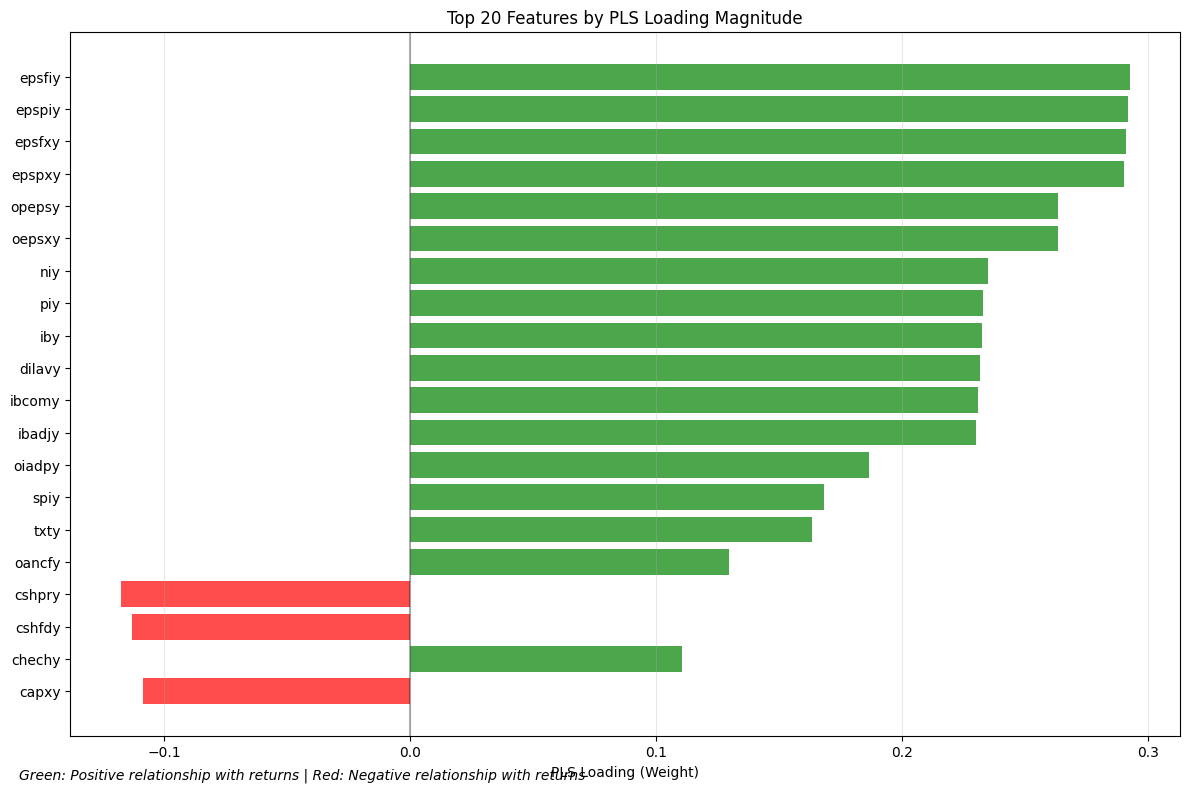

KeyError: "['PERMNO', 'date', 'gvkey'] not found in axis"

In [ ]:
loadings_df = inspect_pls_model(pls_model, top_n=25)

# Plot the loadings
plot_pls_loadings(loadings_df, top_n=20)

# Analyze a subset of predictions
sample_data = merged.head(1000)  # Sample for analysis
X_sample = sample_data.drop(columns=['PERMNO', 'date', 'gvkey'])
X_sample_processed = process_chunk(X_sample.dropna())  # Process the same way
pls_scores = analyze_pls_predictions(pls_model, X_sample_processed)

# Look at the relationship between PLS index and returns
merged_analysis = index_df.merge(returns, on=['date', 'gvkey'])
correlation = merged_analysis['pls_index'].corr(merged_analysis['MonthlyRet'])
print(f"Overall correlation between PLS index and returns: {correlation:.4f}")

In [ ]:
index_df.to_csv('Predictors/FirmCharacIndex.csv')

## B

In [64]:
def inspect_pls_model(pls_model, feature_names=None, top_n=20):
    """
    Comprehensive inspection of a fitted PLS model.
    
    Parameters:
    -----------
    pls_model : PLSRegression
        Fitted PLS model
    feature_names : list, optional
        Names of features used in training
    top_n : int, default=20
        Number of top features to display
    """
    
    print("=" * 60)
    print("PLS MODEL INSPECTION")
    print("=" * 60)
    
    # 1. Basic model information
    print(f"Number of components: {pls_model.n_components}")
    print(f"Number of features: {pls_model.n_features_in_}")
    
    if hasattr(pls_model, 'feature_names_in_'):
        feature_names = pls_model.feature_names_in_
        print(f"Feature names available: Yes ({len(feature_names)} features)")
    else:
        print("Feature names available: No")
        if feature_names is None:
            feature_names = [f"Feature_{i}" for i in range(pls_model.n_features_in_)]
    
    print()
    
    # 2. Component loadings (weights) - these show how much each feature contributes
    print("FEATURE LOADINGS (X-weights):")
    print("-" * 40)
    
    # X loadings for first component
    x_loadings = pls_model.x_weights_[:, 0]  # First component
    
    # Create DataFrame for easier inspection
    loadings_df = pd.DataFrame({
        'feature': feature_names,
        'loading': x_loadings,
        'abs_loading': np.abs(x_loadings)
    }).sort_values('abs_loading', ascending=False)
    
    print(f"Top {top_n} most important features:")
    print(loadings_df.head(top_n).to_string(index=False))
    print()
    
    # 3. Explained variance
    if hasattr(pls_model, 'x_scores_') and hasattr(pls_model, 'y_scores_'):
        # Calculate explained variance for X
        x_var_explained = np.var(pls_model.x_scores_[:, 0]) / np.sum(np.var(pls_model.x_scores_, axis=0)) * 100
        print(f"Variance explained in X by first component: {x_var_explained:.2f}%")
        
        # Calculate explained variance for Y  
        y_var_explained = np.var(pls_model.y_scores_[:, 0]) / np.sum(np.var(pls_model.y_scores_, axis=0)) * 100
        print(f"Variance explained in Y by first component: {y_var_explained:.2f}%")
        print()
    
    # 4. Summary statistics of loadings
    print("LOADING STATISTICS:")
    print("-" * 20)
    print(f"Mean absolute loading: {np.mean(np.abs(x_loadings)):.4f}")
    print(f"Std of loadings: {np.std(x_loadings):.4f}")
    print(f"Max loading: {np.max(x_loadings):.4f}")
    print(f"Min loading: {np.min(x_loadings):.4f}")
    print()
    
    # 5. Features with highest positive and negative loadings
    print("DIRECTIONAL IMPORTANCE:")
    print("-" * 25)
    print(f"Top {min(10, top_n//2)} features with POSITIVE loadings (increase returns):")
    positive_features = loadings_df[loadings_df['loading'] > 0].head(min(10, top_n//2))
    for _, row in positive_features.iterrows():
        print(f"  {row['feature']}: {row['loading']:.4f}")
    
    print(f"\nTop {min(10, top_n//2)} features with NEGATIVE loadings (decrease returns):")
    negative_features = loadings_df[loadings_df['loading'] < 0].head(min(10, top_n//2))
    for _, row in negative_features.iterrows():
        print(f"  {row['feature']}: {row['loading']:.4f}")
    
    return loadings_df

def plot_pls_loadings(loadings_df, top_n=20, figsize=(12, 8)):
    """
    Plot the PLS loadings for visualization.
    
    Parameters:
    -----------
    loadings_df : pd.DataFrame
        DataFrame with feature loadings from inspect_pls_model
    top_n : int, default=20
        Number of top features to plot
    figsize : tuple, default=(12, 8)
        Figure size for the plot
    """
    
    # Plot top features by absolute loading
    plt.figure(figsize=figsize)
    
    # Get top features
    top_features = loadings_df.head(top_n).copy()
    
    # Create color map (positive = green, negative = red)
    colors = ['green' if x > 0 else 'red' for x in top_features['loading']]
    
    # Create horizontal bar plot
    plt.barh(range(len(top_features)), top_features['loading'], color=colors, alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('PLS Loading (Weight)')
    plt.title(f'Top {top_n} Features by PLS Loading Magnitude')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Add grid for easier reading
    plt.grid(axis='x', alpha=0.3)
    
    # Invert y-axis so highest absolute loading is at top
    plt.gca().invert_yaxis()
    
    # Add text explanation
    plt.figtext(0.02, 0.02, 'Green: Positive relationship with returns | Red: Negative relationship with returns', 
                fontsize=10, style='italic')
    
    plt.tight_layout()
    plt.show()

def analyze_pls_predictions(pls_model, X_test, y_test=None):
    """
    Analyze PLS model predictions and scores.
    
    Parameters:
    -----------
    pls_model : PLSRegression
        Fitted PLS model
    X_test : pd.DataFrame or np.array
        Test features
    y_test : array-like, optional
        Test targets for comparison
    """
    
    # Get PLS scores (the index values)
    pls_scores = pls_model.transform(X_test)[:, 0]
    
    print("PLS SCORES ANALYSIS:")
    print("-" * 25)
    print(f"Number of predictions: {len(pls_scores)}")
    print(f"Score statistics:")
    print(f"  Mean: {np.mean(pls_scores):.4f}")
    print(f"  Std: {np.std(pls_scores):.4f}")
    print(f"  Min: {np.min(pls_scores):.4f}")
    print(f"  Max: {np.max(pls_scores):.4f}")
    print(f"  25th percentile: {np.percentile(pls_scores, 25):.4f}")
    print(f"  75th percentile: {np.percentile(pls_scores, 75):.4f}")
    
    if y_test is not None:
        # Calculate correlation with actual returns
        correlation = np.corrcoef(pls_scores, y_test)[0, 1]
        print(f"\nCorrelation with actual returns: {correlation:.4f}")
    
    return pls_scores



PLS MODEL INSPECTION
Number of components: 1
Number of features: 39
Feature names available: Yes (39 features)

FEATURE LOADINGS (X-weights):
----------------------------------------
Top 25 most important features:
feature   loading  abs_loading
 epsfiy  0.292308     0.292308
 epspiy  0.291666     0.291666
 epsfxy  0.290855     0.290855
 epspxy  0.290144     0.290144
 opepsy  0.263344     0.263344
 oepsxy  0.263248     0.263248
    niy  0.234614     0.234614
    piy  0.232567     0.232567
    iby  0.232269     0.232269
 dilavy  0.231660     0.231660
 ibcomy  0.230753     0.230753
 ibadjy  0.230043     0.230043
 oiadpy  0.186416     0.186416
   spiy  0.168118     0.168118
   txty  0.163210     0.163210
 oancfy  0.129482     0.129482
 cshpry -0.117583     0.117583
 cshfdy -0.112945     0.112945
 chechy  0.110382     0.110382
  capxy -0.108543     0.108543
 fincfy -0.096861     0.096861
 dilady  0.078315     0.078315
   miiy  0.069714     0.069714
  nopiy -0.069684     0.069684
  xidoy  0

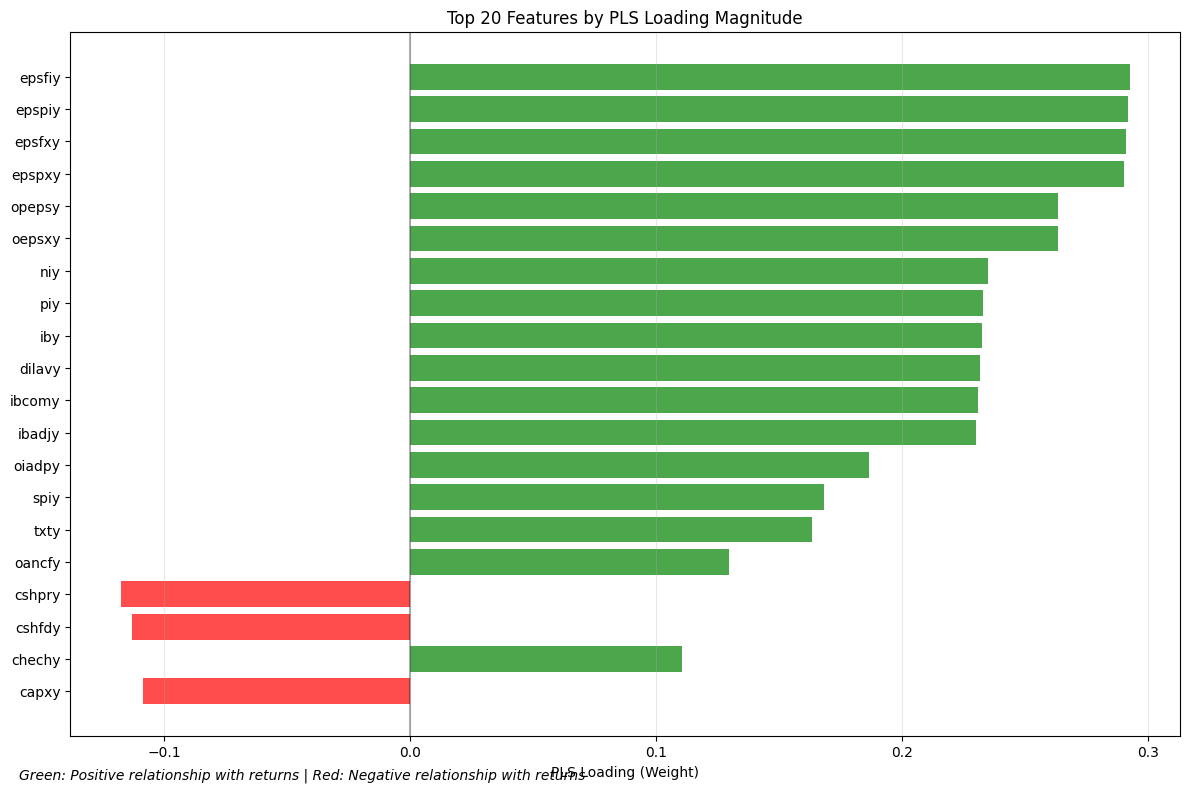

Overall correlation between PLS index and returns: 0.0327


In [65]:
loadings_df_cusip = inspect_pls_model(pls_model_cusip, top_n=25)

# Plot the loadings
plot_pls_loadings(loadings_df_cusip, top_n=20)

# Analyze a subset of predictions
sample_data_cusip = merged_data_cusip.head(1000)  # Sample for analysis
X_sample_cusip = sample_data_cusip.drop(columns=['CUSIP', 'date_firms'])
X_sample_processed_cusip = process_chunk(X_sample_cusip.dropna())  # Process the same way

# Look at the relationship between PLS index and returns
merged_analysis_cusip = index_df_cusip.merge(returns_cusip, on=['date', 'CUSIP'])
correlation_cusip = merged_analysis_cusip['pls_index'].corr(merged_analysis_cusip['MonthlyRet'])
print(f"Overall correlation between PLS index and returns: {correlation_cusip:.4f}")

In [66]:
index_df_cusip.to_csv('Predictors/FirmCharacIndex_cusip.csv')